In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix

from keras.optimizers import Adam


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data loading and preprocessing

In [2]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset()     

Dataset arranged in ./data


In [3]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=2)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=2)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

batch_size = 16
nb_classes = 2
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC", data_aug=True)
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC")
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC")

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Train set size:  266
Validation set size:  67
Test set size:  85
Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Scan Visualization

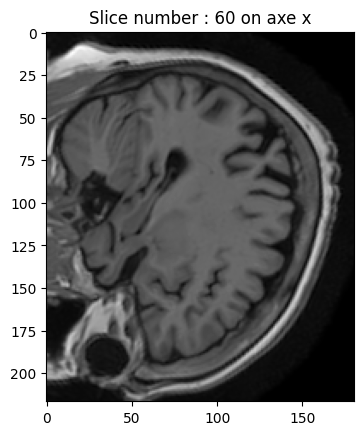

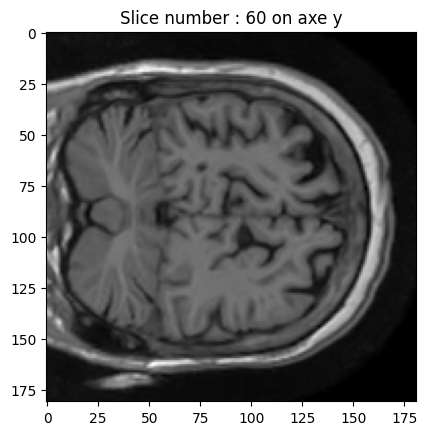

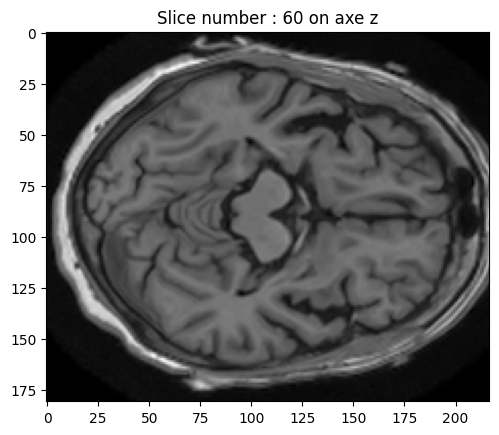

In [4]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()
    
img = nib.load(train_set[0])
show_2D(img.get_fdata(), 60, "x")
show_2D(img.get_fdata(), 60, "y")
show_2D(img.get_fdata(), 60, "z")

Imbalanced Data

{'AD': 191, 'CN': 227}


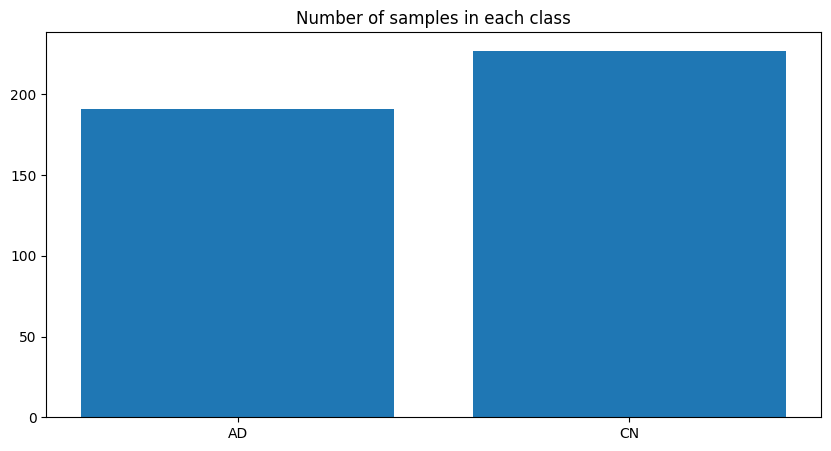

In [5]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["AD", "CN", "PMCI", "SMCI"]
if nb_classes == 2:
    class_names = ["AD", "CN"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

3D Convolutional Neural Network

In [6]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.3)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 20, 40, 8)     0         
 D)                                                              
                                

/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model training

In [7]:
# checkpoint
filepath="classifier3D_test-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [ ]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=20,
)

Epoch 1/20


I0000 00:00:1702133262.276521   78702 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6654
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to classifier3D_test-01-0.50.hdf5
17/17 [==============================] - 51s 3s/step - loss: 0.6141 - accuracy: 0.6654 - val_loss: 7.1429 - val_accuracy: 0.5000
Epoch 2/20


/home/prtissot/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8083
Epoch 2: val_accuracy did not improve from 0.50000
17/17 [==============================] - 44s 3s/step - loss: 0.4631 - accuracy: 0.8083 - val_loss: 3.4569 - val_accuracy: 0.5000
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8271
Epoch 3: val_accuracy improved from 0.50000 to 0.56250, saving model to classifier3D_test-03-0.56.hdf5
17/17 [==============================] - 41s 2s/step - loss: 0.4057 - accuracy: 0.8271 - val_loss: 0.9275 - val_accuracy: 0.5625
Epoch 4/20
17/17 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8759
Epoch 4: val_accuracy did not improve from 0.56250
17/17 [==============================] - 43s 3s/step - loss: 0.3411 - accuracy: 0.8759 - val_loss: 4.7954 - val_accuracy: 0.5000
Epoch 5/20
17/17 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.8985
Epoch 5: val_accuracy improved from 0.56250

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


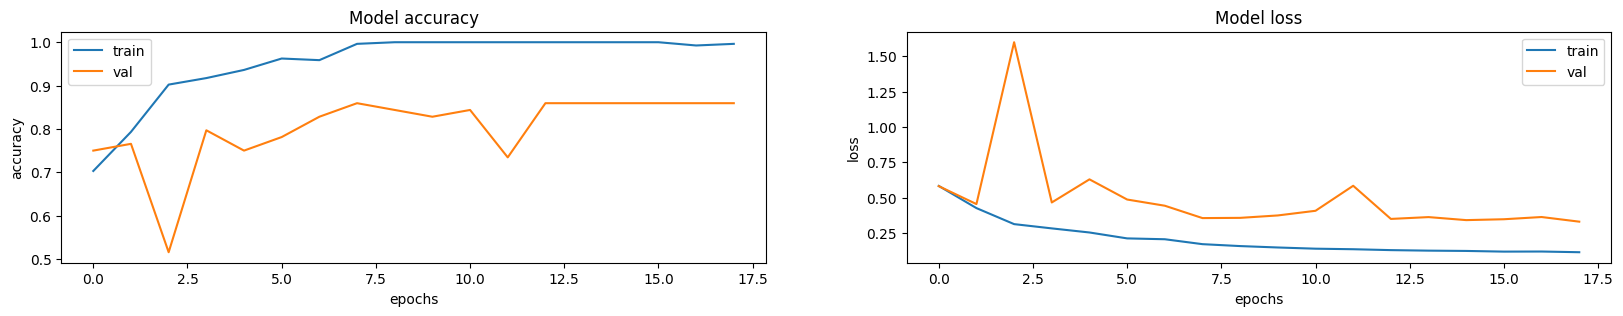

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [10]:
model.evaluate(test_sequence, verbose=1)

6/6 [==============================] - 11s 2s/step - loss: 0.4464 - accuracy: 0.8000


[0.44640278816223145, 0.800000011920929]